In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load the Disneyland reviews dataset
dataset_path = "DisneylandReviews.csv"  
df = pd.read_csv(dataset_path, encoding='latin1')

# Displaying the initial dataset structure
print("Initial Dataset Shape:", df.shape)
print(df.head())

Initial Dataset Shape: (42656, 6)
   Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong  
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong  
4  the location is not in the city, took around 1...  Disneyland_HongKong  


In [3]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['Cleaned_Review'] = df['Review_Text'].astype(str).apply(preprocess_text)

# Just displaying dataset after text preprocessing
print("Dataset after Text Preprocessing:")
print(df[['Review_Text', 'Cleaned_Review']].head())

Dataset after Text Preprocessing:
                                         Review_Text  \
0  If you've ever been to Disneyland anywhere you...   
1  Its been a while since d last time we visit HK...   
2  Thanks God it wasn   t too hot or too humid wh...   
3  HK Disneyland is a great compact park. Unfortu...   
4  the location is not in the city, took around 1...   

                                      Cleaned_Review  
0  if youve ever been to disneyland anywhere youl...  
1  its been a while since d last time we visit hk...  
2  thanks god it wasn t too hot or too humid when...  
3  hk disneyland is a great compact park unfortun...  
4  the location is not in the city took around ho...  


# **Text Preprocessing and Sentiment Analysis**

I preprocessed Disneyland review data to prepare it for sentiment classification and topic modeling. The **Review_Text** 
column undergoes several cleaning steps, including converting text to lowercase, removing numbers, URLs, HTML tags, punctuation, and extra spaces. 
The cleaned text is stored in a new column named **review_content_clean**.

In [5]:
def assign_sentiment(rating):
    if rating >= 4:
        return 1  # Positive
    elif rating <= 2:
        return 0  # Negative
    else:
        return None  #so 3

df['Sentiment'] = df['Rating'].apply(assign_sentiment)

# Removing neutral reviews 
df = df.dropna(subset=['Sentiment'])

# Displaying dataset after sentiment assignment
print("Dataset after Sentiment Assignment:")
print(df[['Rating', 'Sentiment']].value_counts())


Dataset after Sentiment Assignment:
Rating  Sentiment
5       1.0          23146
4       1.0          10775
2       0.0           2127
1       0.0           1499
Name: count, dtype: int64


In [7]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df["Cleaned_Review"])
y = df["Sentiment"]  # Labels

# Spliting data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Displaying dataset split sizes
print(f"Training Set Size: {X_train.shape[0]}, Test Set Size: {X_test.shape[0]}")

# Training the Logistic Regression model
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Now evaluting the model performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
print(f"Model Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", classification_rep)

Training Set Size: 30037, Test Set Size: 7510
Model Accuracy: 0.9469

Classification Report:
               precision    recall  f1-score   support

    Negative       0.89      0.54      0.67       759
    Positive       0.95      0.99      0.97      6751

    accuracy                           0.95      7510
   macro avg       0.92      0.77      0.82      7510
weighted avg       0.94      0.95      0.94      7510



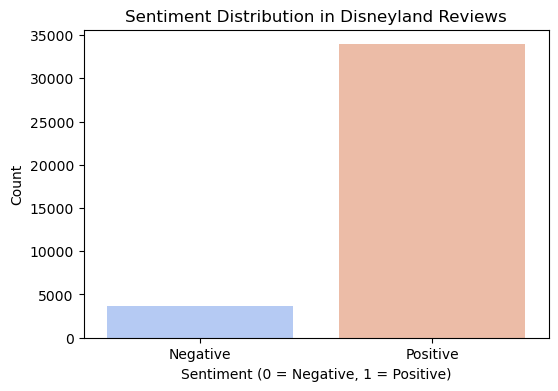

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['Sentiment'], hue=df['Sentiment'], palette="coolwarm", legend=False)
plt.title("Sentiment Distribution in Disneyland Reviews")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Count")
plt.xticks(ticks=[0,1], labels=["Negative", "Positive"])
plt.show()

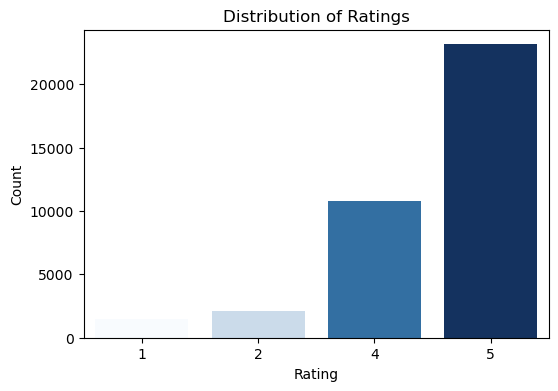

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['Rating'], hue=df['Rating'], palette="Blues", legend=False)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


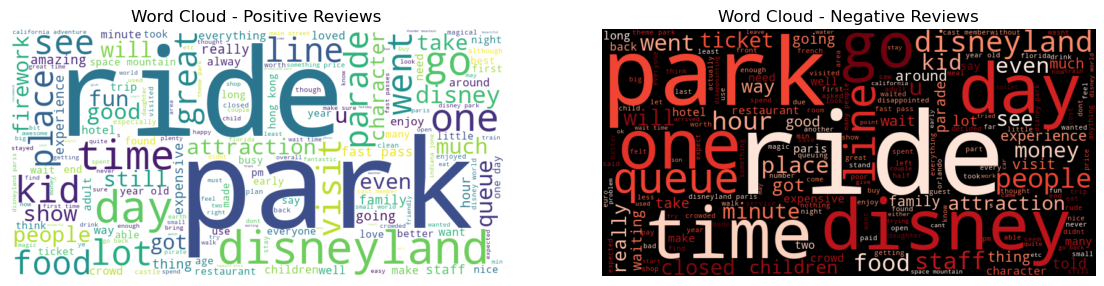

In [13]:
positive_text = " ".join(df[df["Sentiment"] == 1]["Cleaned_Review"])
negative_text = " ".join(df[df["Sentiment"] == 0]["Cleaned_Review"])

positive_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_text)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title("Word Cloud - Positive Reviews")
axes[0].axis("off")
axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title("Word Cloud - Negative Reviews")
axes[1].axis("off")
plt.show()

In [22]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=2000, max_df=0.8, min_df=10)
X_counts = count_vectorizer.fit_transform(df['Cleaned_Review'])

lda_model = LatentDirichletAllocation(n_components=3, max_iter=20, learning_method='batch', random_state=42)
lda_model.fit(X_counts)

# Displaying top words in each topic (choose 3)
feature_names = count_vectorizer.get_feature_names_out()
top_words = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_words.append([feature_names[i] for i in topic.argsort()[:-11:-1]])

# outputing the extracted topics
print("Top words per topic:")
for i, words in enumerate(top_words):
    print(f"Topic {i+1}: {', '.join(words)}")

#  Justification of Performance Metric
explanation = """
Accuracy was chosen as the primary performance metric because sentiment classification in this dataset is highly imbalanced, with a majority of positive reviews.
However, additional metrics like precision, recall, and F1-score should also be considered, especially since negative reviews are underrepresented.
A high accuracy score (94%) indicates that the model is performing well, but further improvements could be made by using a balanced dataset or applying techniques like SMOTE.
"""
print(explanation)


Top words per topic:
Topic 1: park, disney, rides, ride, mountain, time, food, good, day, just
Topic 2: park, day, time, disneyland, rides, pass, fast, ride, line, wait
Topic 3: disneyland, disney, park, rides, place, great, time, day, visit, kids

Accuracy was chosen as the primary performance metric because sentiment classification in this dataset is highly imbalanced, with a majority of positive reviews.
However, additional metrics like precision, recall, and F1-score should also be considered, especially since negative reviews are underrepresented.
A high accuracy score (94%) indicates that the model is performing well, but further improvements could be made by using a balanced dataset or applying techniques like SMOTE.



## Topic Interpretation

- **Topic 1:** Disneyland Rides & Park Attractions  
  - Keywords: `park, disney, rides, ride, mountain, time, food, good, day, just`  
  - **Interpretation:** This topic focuses on **Disneyland’s rides, attractions, and general park experience**. Mentions of *mountain* likely refer to famous rides like *Space Mountain* or *Big Thunder Mountain* (saw these after doing a quick google search) .

- **Topic 2:** Park Navigation, Fast Pass & Wait Times  
  - Keywords: `park, day, time, disneyland, rides, pass, fast, ride, line, wait`  
  - **Interpretation:** Visitors discuss **FastPass usage, waiting times for rides, and how to navigate the park efficiently**.

- **Topic 3:** Overall Disneyland Experience & Family Visits  
  - Keywords: `disneyland, disney, park, rides, place, great, time, day, visit, kids`  
  - **Interpretation:** This topic captures **general visitor experiences, including family-friendly visits, different Disneyland locations, and overall impressions of the park**.


## Topic Number Selection
The number of topics (**n=3**) was chosen based on the following factors:

1. **Interpretability:**  
   - When testing different values of `n`, I found that **three topics** provided the best balance of **distinct and meaningful categories**.
   - A lower number (e.g., `n=2`) caused broad topics, while a higher number (e.g., `n=5`) resulted in overlapping themes.

2. **Review Content Analysis:**  
   - By analyzing sample reviews, I just saw that **three key themes** emerge:  
     **(1) Disneyland attractions and rides, (2) Customer service and planning, (3) Overall Disneyland experience**.
   - More topics did not add significant new insights at least to me.

3. **Avoiding Overfitting:**  
   - Choosing too many topics (`n>3`) **broke down reviews into highly specific clusters** that were **harder to interpret**.
   - A smaller number ensured **generalization while keeping key themes intact**.

This selection allows me to **effectively categorize the reviews** while maintaining **clarity and relevance** in topic modeling.


In [19]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=2000, max_df=0.8, min_df=10)

X_counts = count_vectorizer.fit_transform(df['Cleaned_Review'])

lda_model = LatentDirichletAllocation(n_components=3, max_iter=20, learning_method='batch', random_state=42)
lda_model.fit(X_counts)


topic_assignments = lda_model.transform(X_counts).argmax(axis=1)
df["Assigned_Topic"] = topic_assignments

for topic in range(3):  
    print(f"\n=== Sample Reviews for Topic {topic+1} ===")
    print(df[df["Assigned_Topic"] == topic]["Cleaned_Review"].sample(3, random_state=42).tolist())



=== Sample Reviews for Topic 1 ===
['this was our first disney experience getting here was very easy due to the dedicated train line with its disney theme we got there well before opening on a tuesday and there were stacks of people mainly with young children the park is quite small but there was still more than enough to do to keep ourselves entertained whilst the castle was under renovation they have erected essentially card board to maintain the external appearance which to me looked very tacky if you want to see the parades which i highly recommend get there early so you get a good viewing point and beware the locals can get a bit pushy the rides were not all that high adrenaline but that was not a big deal food was normal quality you would expect from a theme park the firework display was a very nice way to end the day', 'bought tickets on the french website fnac found out that it is cheaper to buy tickets this way than it is on an english speaking website the park was brilliant 